In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, cmath, math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401

In [2]:
three_color_matrix = [[0, 1/math.sqrt(3), 1/math.sqrt(3), 1/math.sqrt(3)], [1/math.sqrt(3), 2/3, -1/3, -1/3], [1/math.sqrt(3), -1/3, 2/3, -1/3], [1/math.sqrt(3), -1/3, -1/3, 2/3]]

In [3]:
def quantum_not_reversed(circ, a, result):
    ''' 
    Adds a quantum NOT gate that to the QuantumCircuit circ
    that NOTs quibit a and stores the result on qubit result.
    '''
    circ.cx(a, result)


def quantum_and_reversed(circ, a, b, nand_result, result):
    ''' 
    Adds a quantum AND gate that to the QuantumCircuit circ.
    @return the final output is stored on the qubit result. 
    We also pass in an extra "ancilla" qubit nand_result that is used to store the 
    answer of the first NAND before passiing it along to the quantum_not() function. 
    Also note that we assume the nand_result ancilla is set to state |1> at the outset. 
    '''
    quantum_not_reversed(circ, nand_result, result)
    circ.ccx(a, b, nand_result) 


def quantum_or_reversed(circ, a, b, a_not_result, b_not_result, result):
    '''
    Implements an OR gate using a similar approach to quantum_and().
    We now need two ancilla qubits to store the result of both NOTs.
    '''
    circ.ccx(a_not_result, b_not_result, result)
    quantum_not_reversed(circ, b, b_not_result)
    quantum_not_reversed(circ, a, a_not_result)


def quantum_xor_reversed(circ, a, b, ab_nand_result, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result, and_ancil, result):
    ''' 
    Adds an XOR gate to circuit circ, that computes a XOR b and stores the result on result.
    Five additional ancillas are included to store intermediate results. 
    '''
    quantum_and_reversed(circ, ab_or_result, ab_nand_result, and_ancil, result)
    circ.barrier()
    quantum_or_reversed(circ, a, b, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result)
    circ.barrier()
    circ.ccx(a, b, ab_nand_result)
    circ.barrier()

In [4]:
def initialize_3coloring_grovers_circuit(n, m):
    x_reg = QuantumRegister(2*n, "x_reg")
    clause_ancilla = QuantumRegister(2*5*m, "clause_ancilla")
    clause_outputs = QuantumRegister(2*m, "clause_outputs")
    edges_register = QuantumRegister(m, "edges_register")
    y_reg = QuantumRegister(1, "y_reg")
    x_meas = ClassicalRegister(2*n, "x_meas")
    circ = QuantumCircuit(x_reg, clause_ancilla, clause_outputs, edges_register, y_reg, x_meas)

    circ.x(clause_ancilla)
    circ.x(clause_outputs)
    circ.x(edges_register)
    circ.x(y_reg)
    circ.h(y_reg)
    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [x_reg[i], x_reg[i+1]])

    return circ, x_reg, clause_ancilla, clause_outputs, edges_register, y_reg, x_meas


def quantum_not(circ, a, result):
    ''' 
    Adds a quantum NOT gate that to the QuantumCircuit circ
    that NOTs quibit a and stores the result on qubit result.
    '''
    circ.cx(a, result)


def quantum_and(circ, a, b, nand_result, result):
    ''' 
    Adds a quantum AND gate that to the QuantumCircuit circ.
    @return the final output is stored on the qubit result. 
    We also pass in an extra "ancilla" qubit nand_result that is used to store the 
    answer of the first NAND before passiing it along to the quantum_not() function. 
    Also note that we assume the nand_result ancilla is set to state |1> at the outset. 
    '''
    circ.ccx(a, b, nand_result) 
    quantum_not(circ, nand_result, result)


def quantum_or(circ, a, b, a_not_result, b_not_result, result):
    '''
    Implements an OR gate using a similar approach to quantum_and().
    We now need two ancilla qubits to store the result of both NOTs.
    '''
    quantum_not(circ, a, a_not_result)
    quantum_not(circ, b, b_not_result)
    circ.ccx(a_not_result, b_not_result, result)


def quantum_xor(circ, a, b, ab_nand_result, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result, and_ancil, result):
    ''' 
    Adds an XOR gate to circuit circ, that computes a XOR b and stores the result on result.
    Five additional ancillas are included to store intermediate results. 
    '''
    circ.ccx(a, b, ab_nand_result)
    circ.barrier()
    quantum_or(circ, a, b, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result)
    circ.barrier()
    quantum_and(circ, ab_or_result, ab_nand_result, and_ancil, result)
    circ.barrier()


def quantum_or_simplified(circ, a, b, result):
    '''
    Adds an OR gate to a quantum circuit.
    
    Args:
        QuantumRegisters a, b, and result (result is in state |1>)
    @return:
        a OR b is stored on result. a and b contain original values
    '''
    # apply OR = (NOT a) NAND (NOT b)
    circ.x(a)
    circ.x(b) 

    circ.ccx(a, b, result)
    
    # restore values of a and b 
    circ.x(a)
    circ.x(b) 


def add_clause(circ, vars_reg, edge, c_index, clause_ancilla, edges_register, clause_outputs):
    vertex1 = edge[0] - 1
    vertex2 = edge[1] - 1

    quantum_xor(circ, vars_reg[2*vertex1], vars_reg[2*vertex2], clause_ancilla[10*c_index], 
                clause_ancilla[10*c_index+1], clause_ancilla[10*c_index+2], 
                clause_ancilla[10*c_index+3], clause_ancilla[10*c_index+4], clause_outputs[2*c_index])

    quantum_xor(circ, vars_reg[2*vertex1+1], vars_reg[2*vertex2+1], clause_ancilla[10*c_index+5], 
                clause_ancilla[10*c_index+6], clause_ancilla[10*c_index+7], 
                clause_ancilla[10*c_index+8], clause_ancilla[10*c_index+9], clause_outputs[2*c_index+1])

    quantum_or_simplified(circ, clause_outputs[2*c_index], clause_outputs[2*c_index+1], edges_register[c_index])


def add_clause_reverse(circ, vars_reg, edge, c_index, clause_ancilla, edges_register, clause_outputs):
    vertex1 = edge[0] - 1
    vertex2 = edge[1] - 1
    
    quantum_or_simplified(circ, clause_outputs[2*c_index], clause_outputs[2*c_index+1], edges_register[c_index])

    quantum_xor_reversed(circ, vars_reg[2*vertex1+1], vars_reg[2*vertex2+1], clause_ancilla[10*c_index+5], 
                clause_ancilla[10*c_index+6], clause_ancilla[10*c_index+7], 
                clause_ancilla[10*c_index+8], clause_ancilla[10*c_index+9], clause_outputs[2*c_index+1])

    quantum_xor_reversed(circ, vars_reg[2*vertex1], vars_reg[2*vertex2], clause_ancilla[10*c_index], 
                clause_ancilla[10*c_index+1], clause_ancilla[10*c_index+2], 
                clause_ancilla[10*c_index+3], clause_ancilla[10*c_index+4], clause_outputs[2*c_index])




def add_3color_oracle(circ, edges, x_reg, clause_ancilla, clause_outputs, edges_register, y_reg):
    for c in range(len(edges)):
        edge = edges[c]
        add_clause(circ, x_reg, edge, c, clause_ancilla, edges_register, clause_outputs)

    circ.mct(edges_register, y_reg)

    for c in range(len(edges)-1, -1, -1):
        edge = edges[c]
        add_clause_reverse(circ, x_reg, edge, c, clause_ancilla, edges_register, clause_outputs)


def add_diffuser(circ, vars_reg, n):
    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [vars_reg[i], vars_reg[i+1]])

    matrix = np.identity(2**(2*n))
    for i in range(1, 2**(2*n)):
        matrix[i][i] = -1
    circ.unitary(matrix, vars_reg)

    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [vars_reg[i], vars_reg[i+1]])


def three_coloring_grovers(edges, n, trials):
    N = int(math.sqrt(2**n))
    circ, x_reg, clause_ancilla, clause_outputs, edges_register, y_reg, x_meas = initialize_3coloring_grovers_circuit(n, len(edges))
    for j in range(N):
        add_3color_oracle(circ, edges, x_reg, clause_ancilla, clause_outputs, edges_register, y_reg)
        add_diffuser(circ, x_reg, n)

    circ.measure(x_reg, x_meas)
    result = qis401.simulate_circuit(circ, shots=trials)
    counts = result.get_counts(circ)
    return counts

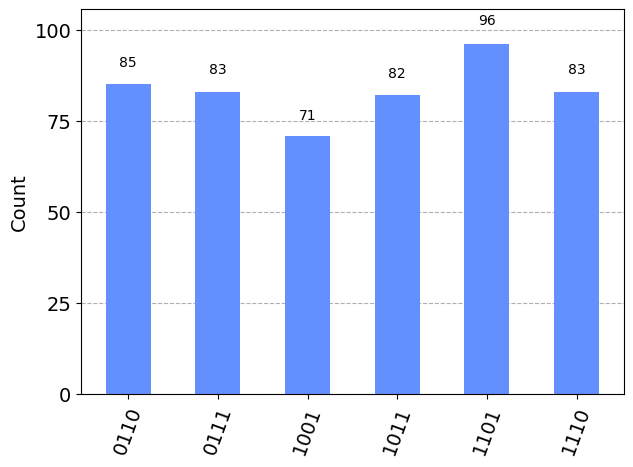

In [5]:
edges = [(1,2)]
n = 2
trials = 500
counts = three_coloring_grovers(edges, n, trials)
plot_histogram(counts)